# Creating a Music Recommender System

## Author: Mitch Allison

## Project Overview:

Music is only good if you can listen to it. We currently have the ability to play any song at any time through streaming services like Spotify or Apple Music.

The hard part is finding music that appeals to you. Not everyone likes the same music so it can be difficult to find songs you really like.




## Business Problem:

Currently, the streaming market is controlled by a couple of streaming giants. These giants have become houshold names(Spotify, Apple Music, etc).One challenge that these streaming giants face is to keep listeners interested. Capturing these listeners can lead to large monetary gains. Here are some quick stats about the streaming industry:
1. Music streaming makes up 84% of the U.S. music industry revenue.
2. Global music subscribers surged 26.4% to 523.9 million during the Covid pandemic.
3. 82.1 million Americans are paid subscribers to on-demand music streaming.

[Source](https://musicalpursuits.com/music-streaming/#:~:text=Music%20streaming%20makes%20up%2084,minutes%20of%20music%20per%20day.)

Although most listeners will have a core set of musical interests, such as classic rock, it's important to find fresh music for them to keep them engaged.

By creating a recommender system to find fresh music for individuals, we can retain subscribers and increase subscriptions. Although we can have curated playlists available to everyone, such as top pop songs, personalized recommendations are an efficient way to keep listeners invested.

My goal with this project was to create a music recommender that could meet the above goals, as well as find some fresh music for my own listening.

I wanted to focus primarily on collaboratory-based recommendations versus content-based recommendations. Using classic rock as an example again, finding new classic rock is as easy as looking at a wikipedia page. It's more difficult to find music that can appeal to a classic rock listener.

## Data Understanding

The data was collected from ListenBrainz. ListenBrainz is open-source and collects data volunteered from the public about the music they're listening to. The data can be pulled as a query from [Google BigQuery](https://console.cloud.google.com/marketplace/product/metabrainz/listenbrainz?project=listenbrainzrecommender) or as a data dump directly from their [website](https://listenbrainz.org/).

This data contains information about the time the song was listened to, the profile that listened to the song, the artist, the album, and the song. There are also unique ID's for each of these datapoints that references an internal corresponding ID in the ListenBrainz API.

This data dates from 2005 to 2018. There is some dirty data, in that there are some songs improperly labeled or with an incorrect play date, but these errors make up less than 1% of the total data.

I originally wanted to do most of this project on my personal PC, but soon found that this would not be possible for several reasons:
1. The data dumps are split into 2 versions: a dump that can be used to setup a ListenBrainz server and a dump of the raw listens. I don't have the knowledge/time to create a server at this time and the raw listens is too large of a file(27GB with 146M rows) to work with on a personal computer.
2. In some EDA with the data, I found that my computer did not have the processing capabilites to create a model I was happy with.

I found that using Google Colab, in conjunction with Google BigQuery would provide the best options for me to proceed with this project. Throughout this notebook you may see magic commands and queries specific to Colab/BigQuery. It was also very helpful to save dataframes to my google drive for working with other notebooks. This helped conserve memory.

The only downside to this approach is that every notebook needs to be authenticated with the appropriate BigQuery/G-Drive, and relevant packages need to be installed in every notebook.

## Baseline Model:

As a dummy model, I created a model that would always recommend the top 25 songs(by listen number). You can look at the original model creation in the [Baseline Model Notebook](baseline.ipynb).

Recommender systems can be harder to rate the performance of than other traditional models, such as classification. I'll be using RMSE and MAE of data reinserted into the model to rate the performance of the models.

In [ ]:
# install scikit-surprise
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Imports
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Imports continued

from surprise import Reader, Dataset, dump
from surprise.prediction_algorithms import SVD, SVDpp, KNNBaseline
from surprise.model_selection import cross_validate, GridSearchCV, train_test_split

In [ ]:
# Google imports to run on colab/with drive

from google.cloud import bigquery

# Authenticate google cloud platform
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

# Authenticate google drive
from google.colab import drive 
drive.mount('/drive')

Authenticated


In [ ]:
# Setup for BigQuery
project_id = 'listenbrainzrecommender'
client = bigquery.Client(project=project_id)

In [ ]:
# Query w/ magic command to get top 25 songs by plays

%%bigquery --project listenbrainzrecommender top25songs_alltime
SELECT
  artist_name,
  track_name,
  COUNT(user_name) AS song_plays

FROM
  `listenbrainz.listenbrainz.listen`

WHERE
  LENGTH(recording_mbid) > 0

GROUP BY
  artist_name,
  track_name

ORDER BY
  song_plays DESC

LIMIT
  25

In [ ]:
top25songs_alltime

,artist_name,track_name,song_plays
0,近藤浩治,Inside the Deku Tree,113342
1,Michael Z. Land,Docks Background Ambience,49199
2,Nirvana,Smells Like Teen Spirit,14871
3,Radiohead,Karma Police,14177
4,Massive Attack,Teardrop,12995
5,Radiohead,Paranoid Android,12868
6,Nirvana,Come as You Are,12555
7,Led Zeppelin,Stairway to Heaven,12340
8,Daft Punk,"Harder, Better, Faster, Stronger",12177
9,Gorillaz,Feel Good Inc.,11992


# Data Preparation: Part 1

## [EDA_Songclass](EDA_songclass.ipynb)

We can see that some songs are overplayed versus their relative popularity. The top 2 songs are relatively unknown. This reveal would lead to some data engineering in the following steps.

The original plan was to create a 'song' class, which would be able to work with the ListenBrainz API and Spotify API to retrieve songs and pertinent song data.

However, this approach had some obvious issues.
1. Sending a query for every song would take far too long.
2. Working with the ListenBrainz API proved too difficult to figure out in order to get simple data.

![ListenBrainzSchema](./Graphs/listenbrainz_schema.png)

3. Creating a class for every song just wouldn't be very useful at the end of the day.
4. Looking at songs with their unique MBID's wasn't any more helpful than retrieving the song artist/name.

For these reasons I dropped this approach.

The data is setup to have one row per listen. There are no ratings associated with this data, which will be an issue we will try to amend in a variety of ways.

Based on some preliminary analysis, most people only listen to a song a single time. This leads to a 'long tail problem' which is ripe for a recommender system.

![Frequency_of_plays_original](./Graphs/frequency_plays.jpg)

In [ ]:
# v2 song class
class Song:
  def __init__(self, artist_name, song_name):
    self.artist_name = artist_name
    self.song_name = song_name
  
  def get_listener_list(self):
    '''
    Gets the listeners for a given song.
    Does not take into account the amount an account has listened to a song.
    Returns a dataframe.
    '''
    self.listeners = client.query('''
      SELECT
        user_name
      FROM
        `listenbrainz.listenbrainz.listen`
      WHERE
        artist_name = \''''
      + self.artist_name + '''\'
        AND
        track_name = \''''
      + self.song_name + '''\'
      GROUP BY
        user_name
      ''').to_dataframe()

    return self.listeners

# FSM

## [FSM1](FSM1.ipynb)
## [FSM2](FSM2.ipynb)

In the first try to create an FSM, I did not have my data in a good format to create a sparce matrix for SVD. In the second attempt, I collected the first 1000 rows to try and create an FSM. 1k rows of data wasn't enough to get a model that predicted anything however, and so we had to increase the rows to 10k.

At this point, we also implemented SVD++, which is the only surprise prediction algorithm that can use implicit data. At this point it's important to note that we still don't have any ratings for these listens.

In [ ]:
# Excerpt from FSM2

# get user-song plays
plays_10000 = client.query('''
SELECT
  user_name, artist_name, track_name
FROM
  `listenbrainz.listenbrainz.listen`
GROUP BY
  user_name, artist_name, track_name
LIMIT
  10000
''').to_dataframe()

# function to get custom song_id
def get_song_id(s):
  try:
    return song_df_cl[(song_df_cl['artist_name'].eq(s['artist_name'])) &
                       (song_df_cl['track_name'].eq(s['track_name']))].index.item()
  except IndexError:
    pass

# create df for only songs, to create unique id's for songs
# unique id will be index
song_df = plays_10000[['artist_name', 'track_name']]
song_df.head()

# drop duplicate songs
song_df_cl = song_df.drop_duplicates()
song_df_cl.head()

plays_10000['song_id'] = plays_10000.apply(get_song_id, axis=1)

plays_10000.drop(columns=['artist_name','track_name'], inplace=True)
plays_10000['song_score'] = 3

# read in values as Surprise dataset 
reader = Reader()
data = Dataset.load_from_df(plays_10000, reader)

# Examine users and items
dataset = data.build_full_trainset()
print('Number of users: ', dataset.n_users, '\n')
print('Number of items: ', dataset.n_items)

# Trying SVD++ with default hyperparameters
svdpp = SVDpp()
cv_svdpp = cross_validate(svdpp, data, n_jobs=-1)

# print out the average score for the test set
for i in cv_svdpp.items():
    print(i)
print('-----------------------')
np.mean(cv_svdpp['test_rmse'])

Number of users:  451 

Number of items:  9908
('test_rmse', array([0.00837746, 0.00893057, 0.01010694, 0.00910788, 0.0090476 ]))
('test_mae', array([0.00497133, 0.00526562, 0.00536348, 0.00541804, 0.00517294]))
('fit_time', (16.07310390472412, 16.873575687408447, 16.402353525161743, 17.31503176689148, 11.390825271606445))
('test_time', (0.018414735794067383, 0.01854705810546875, 0.019716262817382812, 0.04555010795593262, 0.011111736297607422))
-----------------------


0.009114089059302626

## FSM Performance Statistics

We can see here that we have created an FSM, but it's hard to say how well it did.

We can see that the test has a very low RMSE and MAE, but it's not a very good model! We know that this model was trained on 10k rows, but contains 9908 different songs. This means that there are only 92 songs in common with other listeners. The model can basically say that each listener is unique and isn't wrong in that prediction.

# Data Preparation: Part 2

## [Data_prep1](Data_prep1.ipynb)

In preparing the data for more complex modeling, I started running into serious issues. To be honest this is where the brunt of the project took place.

The first issue was with the data size and queries. My goal was to load in as much data as possible, and I was advised to load it all in and then work off of the dataframe. Pandas dataframes can hold up to 100Gb so I didn't predict any problems initially with loading in the 27 Gb of data, especially since I would only be loading in a couple of columns.

However, I ran into significant issues when loading in the data.
1. Even with the ability for Colab to load data directly from BigQuery, it took a very very long time to load in data.
2. Even with the upgrade to Colab Pro, which allocates 25gb of ram to projects, I could not pull all the data. When pulling less than 25gb of data, the data would still go over memory.

The solution that I ended up with was to only load a portion of the data, split up by year. I loaded data from 2016 onward, which contained 37M rows of data. Although this is only a small portion of the total data, this was the most I could work with in a non-cloud environment. This data was about 1.2Gb, and I saved it so that I would not have to wait to pull it every time.

I had also not previously worked with `timestamp` datatypes so that was fun to learn as well.

I also data engineered a new variable called `song_no`. I extracted the artist name/song name from the original dataframe, deleted repeated rows, and created a unique id for every song. This way we could save on df size in the main dataframe and also reference songs by a single integer. We'll be using this more late when we make our predictions.

In [ ]:
#standardSQL
# Went over memory, took hours to get there
query1 = """
SELECT
  *
FROM
  `listenbrainz.listenbrainz.listen`
"""

# Went over memory, even when loading only 3 of 12 fields
query2 = """
SELECT
  user_name,
  artist_name,
  track_name
FROM
  `listenbrainz.listenbrainz.listen`
"""
# get all plays >= year 2016
# Still takes a long time(2 hours) to pull
query3 = '''
SELECT
  user_name, artist_name, track_name
FROM
  `listenbrainz.listenbrainz.listen`
WHERE
  listened_at > '2016-01-01 00:00:00 UTC'
'''

In [ ]:
# Excerpt from Data_prep1

# create df for only songs, to create unique id's for songs
# unique id will be index
# song_df = big_plays[['artist_name', 'track_name']]

# drop duplicate songs
# song_df_cl = song_df.drop_duplicates()

# song_df_cl['song_no'] = song_df_cl.index

# load in cleaned song list
song_df_cl = pd.read_csv('/drive/My Drive/Colab Notebooks/song_table.csv')
song_df_cl.drop(columns=['Unnamed: 0'], inplace=True)
song_df_cl.head()

,artist_name,track_name,song_no
0,Katy B X Mr. Mitch,Heavy,0
1,These Hidden Hands,SZ31X71,1
2,Esben and the Witch,Marking the Heart of a Serpent,2
3,death's dynamic shroud.wmv,Loving Is Easy,3
4,Fuzz,What's In My Head?,4


# Data Preparation: Part 3

## [Create_ratings1](Create_ratings1.ipynb)

The next problem we would need to fix is the issue of missing explicit ratings. Does a single listen to a song carry equal weight as a listen to another song?
A couple of key facts informed our next steps:
1. A listen is defined as 1 user listening to 1 song. The song must be played more than halfway through or for 4 minutes, whichever comes first, in order to be registered as a listen.
2. There isn't a normal distribution for plays per person per song. Most people listen to a song a single time.
3. There are a very small amount of people who listen to a song many times.(One person listend to one song over 6k times!)

I decided to create a rating of 1-5 per user per song based on how many times the person played that song. This distribution was based on the relative distribution of plays. Even after limiting the max amount of plays to 100, any plays above 20 aren't even visable.
![Frequency_of_plays_max100](./Graphs/frequency_plays2.jpg)

In [ ]:
# Minimum rating = 3
# listens['rating'] = 3

# 75%: 2 listens. rating = 4
# listens.loc[listens['listen_no'] == 2, 'rating'] = 4

# 75%+: >2 listens. rating = 5
# listens.loc[listens['listen_no'] > 2, 'rating'] = 5

# Modeling: Part 1

## [GS1](GS1.ipynb)

For our first round of modeling/gridsearching, we used the data prepped in [Create_ratings1]. This data had 2643 users and 4M+ items. I wanted data that would be able to be modeled by a sparce matrix and modeled with Singular Value Decomposition(SVD). The issue here is that there are just too many options and the created matrix goes over memory(25+Gb).

I would need to go back and continue to work on the data.

# Data Preparation: Part 4

## [Create_ratings2](Create_ratings2.ipynb)

Our goal here was to reduce the amount of data present so that I could model it using SVD. We did two things here:

1. Eliminate all listens where 1 person listened to a song 1 time. Although this drops a significant amount of data, our goal here is to do just that in order to model it using SVD.
2. Create a new rating system, where the rating equals the amount of times the person listened to the song, maxed out at 10.

# Modeling: Part 2

## [GS2](GS2.ipynb)

Using the data from [Create_ratings2](Create_ratings2.ipynb), I would gridsearch across many surprise predictors to see which predictor would give the best performance metrics.

With metrics that could predict along user or items, I had to specify along users. The issue was that there were just too many items(2M+) when compared to the amount of users(2.5k).

It's also important to note that I could still only used memory-based predictors, as creating a sparse matrix still went over memory.

In [ ]:
# Sample of GridsearchCV from GS2

# determining the optimal algorithm parameters with GridSearchCV
# Memory based
# KNNBaseline
# User based

sim_options = {
    "name": ["pearson"],
    "k": [20, 40, 60],
    "min_k": [1, 2, 3],
    "user_based": [True],
}

param_grid = {"sim_options": sim_options}

gs_KNNb = GridSearchCV(KNNBaseline, param_grid, cv=5, joblib_verbose=5)

# gs_KNNb.fit(data)
# 71 min to run

# gs_KNNb.best_params

# {'rmse': {'sim_options': {'name': 'pearson',
#    'k': 20,
#    'min_k': 1,
#    'user_based': True}},
#  'mae': {'sim_options': {'name': 'pearson',
#    'k': 20,
#    'min_k': 1,
#    'user_based': True}}}

# gs_KNNb.best_score

# {'rmse': 2.611438296260585, 'mae': 1.999188842719161}

These are the predictors, their optimal parameters, and the resulting performance metrics. (Rating scale of 2-10)

* Algorithm: KNNWithMeans
  * Parameters: name: pearson, min_support: 1
  * Metrics:
    * RMSE: 2.682
    * MAE: 2.100
* Algorithm: KNNBaseline
  * Parameters: name: pearson, k: 20, min_k: 1
  * Metrics:
    * RMSE: 2.611
    * MAE: 1.999
* Algorithm: CoClustering
  * Parameters: n_cltr_u: 3, n_cltr_i: 3, n_epochs: 20
  * Metrics: 
    * RMSE: 2.767
    * MAE: 2.160

# Data Preparation: Part 5

## [Create_ratings3](Create_ratings3.ipynb)

At this point, we've found the core issue with creating our SVD model: there are just too many items. Here is the fix that we went with in order to model with SVD:
1. Previously I'd gotten rid of all listens with 1 play per song. Instead, we'll only look at listens from the top played songs.
2. Create a dataframe with only the top 10k songs for gridsearching.
3. First limit plays per person per song at 10 in order to help curb drastic outliers of 1 person listening to 1 song thousands of times.
4. After gridsearching, we'll create our final model with data for the top 100k songs, or 1M songs if possible.
5. Try the modeling with a custom rating of 1-5, as well as the rating of 1-10 based on song plays.

![Frequency_of_plays_1Mmaxsongs](./Graphs/frequency_plays_engineered.jpg)

# Modeling: Part 3

## [GS3](GS3.ipynb)

At this point we have finally reduced our data size enough to model with SVD. Our gridsearch dataframe has 1.3M rows, with 2.5k users and 10k items. This is with ratings from 1-10.

Here are the optimal parameters for SVD:
  * Parameters: n_factors: 150, reg_all: 0.1
  * Metrics: 
    * RMSE: 2.409
    * MAE: 1.784

I also examined the augmented score, where the score was changed to 1-5.
  * Parameters: n_factors: 150, reg_all: 0.09
  * Metrics: 
    * RMSE: 1.199
    * MAE: 0.956



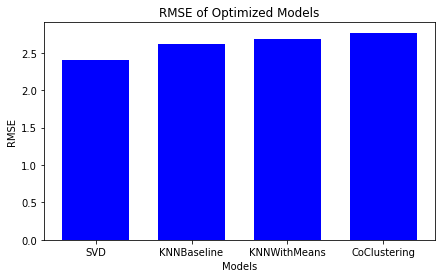

In [ ]:
model_performance_RMSE = {
    'SVD':2.409,
    'KNNBaseline':2.611,
    'KNNWithMeans':2.682,
    'CoClustering':2.767
}

models = list(model_performance_RMSE.keys())
rmse = list(model_performance_RMSE.values())
  
fig = plt.figure(figsize = (7, 4))
 
# creating the bar plot
plt.bar(models, rmse, color ='blue',
        width = 0.7)
 
plt.title("RMSE of Optimized Models")
plt.ylabel("RMSE")
plt.xlabel("Models")
plt.show()

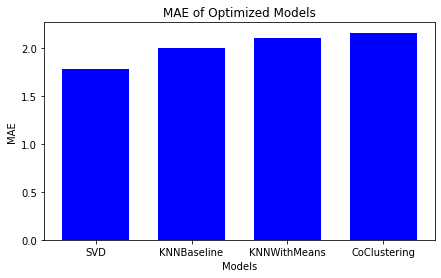

In [ ]:
model_performance_MAE = {
    'SVD':1.784,
    'KNNBaseline':1.999,
    'KNNWithMeans':2.1,
    'CoClustering':2.16
}

models = list(model_performance_MAE.keys())
mae = list(model_performance_MAE.values())
  
fig = plt.figure(figsize = (7, 4))
 
# creating the bar plot
plt.bar(models, mae, color ='blue',
        width = 0.7)
 
plt.title("MAE of Optimized Models")
plt.ylabel("MAE")
plt.xlabel("Models")
plt.show()

# Final Model

## [Final_model](Final_model.ipynb)

With the above perfomance metrics examined, it looks like the model with the best performance is SVD with un-augmented scores. For our final data we used the un-augmented scores, containing 8M+ ratings with 2.6k users and 1M songs.

With that model and parameters, we were able to score the below metrics with a train_test_split.

* Performance metric:
  * RMSE: 2.424

It's important to note here that although the augmented score SVD model performed marginally better in RMSE, it performed far worse in MAE and so I've decided to go with the unaugmented scores.

An important thing to now look at is the size of the models available. The SVD model, trained off 1M songs, with the best metrics takes up a whopping 1.3Gb. This is obviously too large to implement in a lightweight model. If we're looking for a deployment with Streamlit, we have a max ram allocation of 512MB.

As such, we will continue to work with SVD for the best metrics but will reduce the number of songs in the model to create a smaller model. The SVD model trained off of the top 10k songs is only 41Mb with an RMSE of 2.416

In [ ]:
big_model = dump.load(file_name="/drive/My Drive/Colab Notebooks/large_svd.pkl")

In [ ]:
little_model = dump.load(file_name='/drive/My Drive/Colab Notebooks/small_svd.pkl')

# Deployment

## [Streamlit App](https://mitchallison2-song-recommender-streamlitapp-tnfjie.streamlitapp.com/)

For model deployment, I created a streamlit app. This app is able to take in and recommend songs from the top 10k songs using the small SVD model.

This app allows the user to select an artist, a song from that artist, and a rating for those songs. Then they can add that song to a list of songs so that the model can work off of multiple songs.

Then, when the user hits the 'Recommend' button, the app will add the new user's ratings to the dataframe. The app recomputes the SVD model from the small model and then gets the top 10 songs, as determined by the model thinking what that person will like the most.

There is a short video showing the process available on this project's [README](README.md). I've also inserted the source code below as a long string, as it won't run in a notebook.

In [ ]:
app_source_code = """
import streamlit as st
import pandas as pd

from surprise.prediction_algorithms import SVD
from surprise import Reader, Dataset

# Goal: have person be able to select songs from list(top 10k most listened to songs)
# Add these selections to a list
# Feed this list to the model
# Get the outputs of the model(top 5 recommended songs)
# Convert these music numbers back to artist/song via the df
# Display these songs
# extra credit: integrate spotipy to play song demos

top_songs = pd.read_csv("./data/song_table10k.csv")
top_songs.drop(columns=['Unnamed: 0'], inplace=True)

original_data = pd.read_csv('./data/rated_listens_10k.csv')
original_data.drop(columns=['Unnamed: 0'], inplace=True)


# Use session state to save lists
if 'rating_list_use' not in st.session_state:
    st.session_state['rating_list_use'] = []

if 'rating_list_show' not in st.session_state:
    st.session_state['rating_list_show'] = []

if 's_id_list' not in st.session_state:
    st.session_state['s_id_list'] = []

if 'top5_s_id' not in st.session_state:
    st.session_state['top5_s_id'] = []



# Instructions
st.write("# MITCHMUSIC")
st.write("### Instructions")
st.write("#### Select a song and then give it a rating between 1-10.")
st.write("#### Add multiple songs to your list to help improve recommendations.")
st.write("#### Once you have some songs rated, hit the \"RECOMMEND SONGS\" button.")
st.write("#### The computer will calculate your potential top songs.")
st.write("#### Your top 10 song recommendations will appear, sorted by the predicted score.")

userID = 'ishoulddothisbeforethenightbefore'




artist = st.selectbox(label='ARTIST NAME', options=top_songs['artist_name'].unique())

temp_song_df = top_songs.loc[top_songs['artist_name']==artist]

song = st.selectbox(label='SONG NAME', options=temp_song_df['track_name'])

song_id = temp_song_df.loc[temp_song_df['track_name'] == song, 'song_no'].iloc[0]

rating = st.slider(label='RATING', min_value=1, max_value=10)

if st.button(label='ADD SONG TO SONG LIST'):
    input_row_use = {'user_name':userID, 'song_no':song_id, 'rating':rating}
    st.session_state['rating_list_use'].append(input_row_use)
    input_row_show = {'artist':artist, 'song':song, 'rating':rating}
    st.session_state['rating_list_show'].append(input_row_show)
    st.session_state['s_id_list'].append(song_id)


if st.button(label='RESET'):
    st.session_state['rating_list_use'] = []
    st.session_state['rating_list_show'] = []
    st.session_state['s_id_list'] = []
    st.session_state['recommended_song_df'] = pd.DataFrame()


st.write('Current song list:')
st.write(st.session_state['rating_list_show'])


if st.button(label='RECOMMEND SONGS'):
    # st.write(st.session_state['rating_list_use'])
    st.write('Recommender progress:')

    df_temp = pd.DataFrame.from_dict(st.session_state['rating_list_use'])
    # st.write(df_temp)

    new_ratings_df = pd.concat([original_data, df_temp], axis=0)
    # st.write('Concat success')

    # new_ratings_df = original_data.concat(st.session_state['rating_list_use'])
    # st.write(new_ratings_df.tail())

    st.write('Dataset building')
    reader = Reader(rating_scale=(1,10))
    new_data = Dataset.load_from_df(new_ratings_df, reader)
    

    # train a model using new df w/ optimal hyperparameters
    st.write('Recalculating SVD')
    model = SVD(n_factors= 150, reg_all=0.1)
    model.fit(new_data.build_full_trainset())
    st.write('Model Trained')

    recommended_song_list = []
    for s_id in original_data['song_no'].unique():
        if s_id not in st.session_state['s_id_list']:
            recommended_song_list.append( (s_id, model.predict(userID, s_id)[3]))
    # st.write('recommended list created')

    # order the predictions from highest to lowest rated
    recommended_ranked_song_list = []
    recommended_ranked_song_list = sorted(recommended_song_list, key=lambda x:x[1], reverse=True)
    # st.write('recommended list sorted')

    # get top songs
    # list of tuples(song_no, rating)

    top5 = recommended_ranked_song_list[:10]
    st.session_state['top5_s_id'] = list(zip(*top5))[0]
    top5_prob = list(zip(*top5))[1]

    # modify df, show top songs
    top_song_df = top_songs[top_songs['song_no'].isin(st.session_state['top5_s_id'])]

    top_song_df['likely_rating'] = top_song_df['song_no'].map(dict(top5))

    top_song_df.sort_values(by=['likely_rating'], ascending=False, inplace=True)
    top_song_df.set_index('likely_rating', inplace=True)
    top_song_df.drop(columns=['song_no'], inplace=True)

    st.write('RECOMMENDED SONGS:')
    st.write(top_song_df)
"""

# Next Steps

For next steps, there are a lot of potential next steps to take:
1. The first next step I would take is to redevelop this project on Spark or another distributed architechture. This would allow me to work with the full dataset and would help alleviate the issues that I consistently ran into this project in terms of data size and compute limits.
2. I would like to include additional featues. Having the time the song was played is less significant when only looking at the 2 years of data I worked with, but if working with all of the data (2005-2018) it may become more pertinent to work with those additional data points.
3. I would like to include additional features in the deployment as well. One of my stretch goals was to include spotify integration, in order to fetch a 15 second demo of the song, or automatically create a playlist from the recommended songs. I unfortunately ran out of time to add these additional features.
4. I could continue to improve the model. Although an SVD model gives the best metrics, there are so many more models permutations to look at to see if they give better metrics. The small SVD model may also not be super deployable as it still takes some time/computation to get the results. I could get feedback on the app and, if one of the complaints is that the app takes too long, could use one of the other more standard models.
5. Although the original data did not contain any metadata for the songs(length, loudness, dancability, etc.), I could use the spotify API to get additional data for the songs in order to provide a content based recommender as well.

# Conclusion

As a capstone, I will say that I think this project was the correct difficulty. Running into so many issues with data management and data preparation was very informative for how to approach data in a real life environment.

From a technical sense, it's also exciting to be able to provide pretty good recommendations based on people's preferences. I've worked with the app a fair amount to see what songs it recommends and have already found a few novel tunes that I wouldn't have been able to find otherwise.

I encourage you to try the app and find some new songs for your own listening.

If you have any questions or concerns about this project, I also encourage you to reach out and connect with me at my [email](mitch.allison2@gmail.com).